# Применение моделей глубинного обучения

## Импорты, загрузка данных

In [1]:
# Импорты
import pandas as pd
from collections import Counter
from sklearn.metrics import f1_score, precision_score, recall_score, hamming_loss
import gdown
import numpy as np
import torch
import torch.nn as nn
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from torch.utils.data import TensorDataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import ml_utils as mu

### Загрузка данных

In [ ]:
#Сэмпл датасета (10%) для подбора оптимальной модели
# sample_10_id = '17IVd8t37FZ-WULTMCnsUv8vbd6PuzeKx'
# gdown.download(f"https://drive.google.com/uc?id={sample_10_id}", quiet=True)

# 50% датасета (которые поместились в 32гб оперативки)
df_50_id = '12mIlvk7Fb7yfdvoml7dmE-8TuGLh4c-V'
gdown.download(f"https://drive.google.com/uc?id={df_50_id}", quiet=True)

# Если понадобится - полный датасет (400к статей)
# df_100_id = '1YvQ2kxQqq1JJBfzTqygftj_RMOnV0ZTd'
# gdown.download(f"https://drive.google.com/uc?id={df_100_id}", quiet=False)

In [ ]:
df = pd.read_parquet("df_final_50.parquet")

In [5]:
df.head(2)

,author,publication_date,hubs,comments,views,url,reading_time,individ/company,bookmarks_cnt,text_length,rating_new,text_pos_tags,tags_tokens,title_tokens,text_tokens
0,LivingDead,2011-09-13 14:45:04+00:00,Разработка игр,16,34000,https://habr.com/ru/articles/128368/,2.0,individual,78.0,2677,21.0,"[PRON, ADJ, NOUN, NOUN, PRON, VERB, AUX, VERB,...","[minecraft, noise, perlin, d, landscape]","[генерация, ландшафт, minecraft]","[добрый, время, суток, поделиться, личный, опы..."
1,AlfaTeam,2022-09-07 12:19:42+00:00,"Блог компании Альфа-Банк, JavaScript, Программ...",13,19000,https://habr.com/ru/companies/alfa/articles/68...,8.0,company,44.0,12132,18.0,"[PRON, VERB, ADP, ADJ, NOUN, PROPN, PRON, VERB...","[react, react, router, react, reactrouter, мар...","[переходить, reactrouter, v, подводный, камень...","[перейти, шестой, версия, reactrouter, помочь,..."


In [6]:
# Выделение рейтинга статьи
df['rating_level'] = mu.categorize_ratings(df)

# Предобработка датасета: фильтрация, объединение текстовых токенов,
# кодировка меток(хабов) и преобразование рейтингов
(df_prepr, y_multi_reduced, selector, 
index_to_label, mlb, 
y_rating, inverse_rating_mapping, indices) = mu.df_preprocess(df)

## Полносвязная модель

### Предобработка данных

In [7]:
# Оставим только необходимые столбцы
X = df_prepr[['text_combined']].copy()
text_col = 'text_combined'

# Выделям матрицы признаков признаков для хабов и рейтинга
X_hubs = X.iloc[indices].copy()
X_rating = X.copy()

# Разделение на обучающую и тестовую выборки для предсказания хабов (тем) статей
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_hubs, y_multi_reduced, test_size=0.25)

# Разделение на обучающую и тестовую выборки для предсказания рейтинга статьи
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_rating, y_rating, test_size=0.25)

In [8]:
# Пайплайн для предобработки текстовых данных
text_pipe= Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
    ('svd', TruncatedSVD(n_components=50, random_state=42))])

# Хабы
X_train_h_pipe = text_pipe.fit_transform(X_train_h['text_combined'])
X_test_h_pipe = text_pipe.transform(X_test_h['text_combined'])

# Рейтинг
X_train_r_pipe = text_pipe.fit_transform(X_train_r['text_combined'])
X_test_r_pipe = text_pipe.transform(X_test_r['text_combined'])

In [9]:
# Количество классов
n_classes_h = len(y_train_h[0])
n_classes_r = len(set(y_train_r))

# DataLoader
batch_size = 64
def make_loader(X, y, task_type, shuffle=True):
    X_t = torch.from_numpy(X).float()
    if task_type == 'hubs':
        y_t = torch.from_numpy(np.array(y)).float()
    elif task_type == 'rating':
        y_t = torch.from_numpy(np.array(y)).long()
    ds = TensorDataset(X_t, y_t)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

# loader для хабов
train_loader_h = make_loader(X_train_h_pipe, y_train_h, task_type='hubs', shuffle=True)
test_loader_h  = make_loader(X_test_h_pipe, y_test_h, task_type='hubs',  shuffle=False)

# loader для рейтинга
train_loader_r = make_loader(X_train_r_pipe, y_train_r, task_type='rating', shuffle=True)
test_loader_r  = make_loader(X_test_r_pipe,  y_test_r, task_type='rating',  shuffle=False)

# Перевод вычислений на GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Функции обучения и теста нейросетей

In [10]:
# Функция для оценки модели на тестовой выборке
# Возвращает loss, f1-score по эпохам
def test(model, loader, criterion, model_type):
    loss_log = []
    all_preds = []
    all_targets = []
    model.eval()

    if model_type == 'fc':
        for data, target in loader:
            data, target = data.to(device), target.to(device)

            # forward
            with torch.no_grad():
                y_pred = model(data)
            loss = criterion(y_pred, target)
            loss_log.append(loss.item())

            # predict
            if isinstance(criterion, nn.BCEWithLogitsLoss):
                pred_probs = torch.sigmoid(y_pred)
                pred_classes = (pred_probs > 0.5).float().cpu().numpy()
            elif isinstance(criterion, nn.CrossEntropyLoss):
                pred_classes = y_pred.argmax(dim=-1).cpu().numpy()

            target_np = target.cpu().numpy()
            all_preds.append(pred_classes)
            all_targets.append(target_np)
    
    elif model_type == 'rnn':
        for tabular, text, target in loader:
            tabular, text, target = tabular.to(device), text.to(device), target.to(device)

            # forward
            with torch.no_grad():
                y_pred = model(tabular, text)
            loss = criterion(y_pred, target)
            loss_log.append(loss.item())

            # predict
            if isinstance(criterion, nn.BCEWithLogitsLoss):
                pred_probs = torch.sigmoid(y_pred)
                pred_classes = (pred_probs > 0.5).float().cpu().numpy()
            elif isinstance(criterion, nn.CrossEntropyLoss):
                pred_classes = y_pred.argmax(dim=-1).cpu().numpy()

            target_np = target.cpu().numpy()
            all_preds.append(pred_classes)
            all_targets.append(target_np)

    # Объединяем предсказания и метки
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    # Считаем метрики
    f1 = f1_score(all_targets, all_preds, average='micro')
    precision = precision_score(all_targets, all_preds, average='micro', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='micro', zero_division=0)
    hamming = hamming_loss(all_targets, all_preds)

    return np.mean(loss_log), f1, precision, recall, hamming

# Функция обучения модели в течение 1 эпохи
# Возвращает loss и f1-score по батчам
def train_epoch(model, optimizer, train_loader, criterion, model_type):
    loss_log = []
    f1_log = []
    model.train()

    if model_type == 'fc':
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            # zero gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            y_pred = model(data)
            loss = criterion(y_pred, target)
            loss.backward()
            optimizer.step()
        
            # Метрики
            if isinstance(criterion, nn.BCEWithLogitsLoss):
                pred_probs = torch.sigmoid(y_pred)
                pred_classes = (pred_probs > 0.5).float().cpu().numpy()
            elif isinstance(criterion, nn.CrossEntropyLoss):
                pred_classes = y_pred.argmax(dim=-1).cpu().numpy()

            target_np = target.cpu().numpy()
            f1 = f1_score(target_np, pred_classes, average='micro')
            loss_log.append(loss.item())
            f1_log.append(f1)

    elif model_type == 'rnn':
        for tabular, text, target in train_loader:
            tabular, text, target = tabular.to(device), text.to(device), target.to(device)

            # zero gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            y_pred = model(tabular, text)
            loss = criterion(y_pred, target)
            loss.backward()
            optimizer.step()
        
            # Метрики
            if isinstance(criterion, nn.BCEWithLogitsLoss):
                pred_probs = torch.sigmoid(y_pred)
                pred_classes = (pred_probs > 0.5).float().cpu().numpy()
            elif isinstance(criterion, nn.CrossEntropyLoss):
                pred_classes = y_pred.argmax(dim=-1).cpu().numpy()

            target_np = target.cpu().numpy()
            f1 = f1_score(target_np, pred_classes, average='micro')
            loss_log.append(loss.item())
            f1_log.append(f1)

    return loss_log, f1_log

In [11]:
# Общая функция для обучения/теста модели
def train(model, optimizer, n_epochs, train_loader, test_loader,
          train_epoch, test_func, task_type, criterion, model_type, scheduler):

    # логи по эпохам
    train_loss_log, train_f1_log = [], []
    test_loss_log, test_f1_log = [], []
    test_prec_log, test_rec_log, test_ham_log = [], [], []

    for epoch in range(n_epochs):
        # train
        batch_losses, batch_f1s = train_epoch(model, optimizer, train_loader, criterion, model_type)
        train_loss_log.append(np.mean(batch_losses))
        train_f1_log.append(np.mean(batch_f1s))

        # test
        test_loss, test_f1, test_prec, test_rec, test_ham = test_func(model, test_loader, criterion, model_type)
        test_loss_log.append(test_loss)
        test_f1_log.append(test_f1)
        test_prec_log.append(test_prec)
        test_rec_log.append(test_rec)
        test_ham_log.append(test_ham)

        # scheduler step
        scheduler.step(test_loss)

        # выводим раз в 5 эпох
        if epoch % 5 == 0:
            print(f"Epoch {epoch}")
            print(f" train loss: {np.mean(batch_losses):.4f}, train f1: {np.mean(batch_f1s):.4f}")

            if task_type == 'hubs':
                print(f" test loss: {np.mean(test_loss):.4f}, test f1: {test_f1:.4f}, test precision: {test_prec:.4f}, test recall: {test_rec:.4f}, test hamming: {test_ham:.4f}\n")
            elif task_type == 'rating':
                print(f" test loss: {test_loss:.4f}, test f1: {test_f1:.4f}, test hamming: {test_ham:.4f}\n")

    return (train_loss_log, train_f1_log,
            test_loss_log, test_f1_log,
            test_prec_log, test_rec_log, test_ham_log)

### Архитектура нейросети, обучение

In [12]:
# Архитектура полносвязной модели
class FCNet(nn.Module):
    def __init__(self, input_size, hidden_size, n_classes, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Linear(hidden_size//2, n_classes)
        )

    def forward(self, x):
        pred = self.net(x)
        return pred

In [13]:
# Задаём все переменные для предсказания хабов
fcnet_h = FCNet(input_size = X_train_h_pipe.shape[1],
                hidden_size = 256,
                n_classes = n_classes_h,
                dropout=0.3).to(device)
optimizer_h = torch.optim.Adam(fcnet_h.parameters(), lr=1e-3)
scheduler_h = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_h, mode='min', factor=0.1, patience=3)

# Задаём все переменные для предсказания рейтинга
fcnet_r = FCNet(input_size = X_train_r_pipe.shape[1],
                hidden_size = 128,
                n_classes = n_classes_r,
                dropout=0.3).to(device)

optimizer_r = torch.optim.Adam(fcnet_r.parameters(), lr=1e-3)
scheduler_r = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_r, mode='min', factor=0.1, patience=3)

In [14]:
# Обучаем модель хабов
(train_loss_log, train_f1_log, test_loss_log, test_f1_log, 
 test_prec_log, test_rec_log, test_ham_log) = train(
    fcnet_h, optimizer_h, 51, train_loader_h, 
    test_loader_h, train_epoch, test, 
    task_type='hubs', criterion=nn.BCEWithLogitsLoss(), 
    model_type='fc', scheduler=scheduler_h)

Epoch 0
 train loss: 0.1043, train f1: 0.1382
 test loss: 0.0732, test f1: 0.3187, test precision: 0.6843, test recall: 0.2077, test hamming: 0.0236

Epoch 5
 train loss: 0.0653, train f1: 0.4239
 test loss: 0.0629, test f1: 0.4450, test precision: 0.7107, test recall: 0.3239, test hamming: 0.0215

Epoch 10
 train loss: 0.0625, train f1: 0.4518
 test loss: 0.0609, test f1: 0.4779, test precision: 0.7009, test recall: 0.3626, test hamming: 0.0211

Epoch 15
 train loss: 0.0612, train f1: 0.4627
 test loss: 0.0600, test f1: 0.4903, test precision: 0.7005, test recall: 0.3771, test hamming: 0.0209

Epoch 20
 train loss: 0.0603, train f1: 0.4727
 test loss: 0.0593, test f1: 0.4928, test precision: 0.7076, test recall: 0.3781, test hamming: 0.0207

Epoch 25
 train loss: 0.0597, train f1: 0.4807
 test loss: 0.0591, test f1: 0.4980, test precision: 0.7072, test recall: 0.3843, test hamming: 0.0206

Epoch 30
 train loss: 0.0592, train f1: 0.4853
 test loss: 0.0589, test f1: 0.5052, test precisi

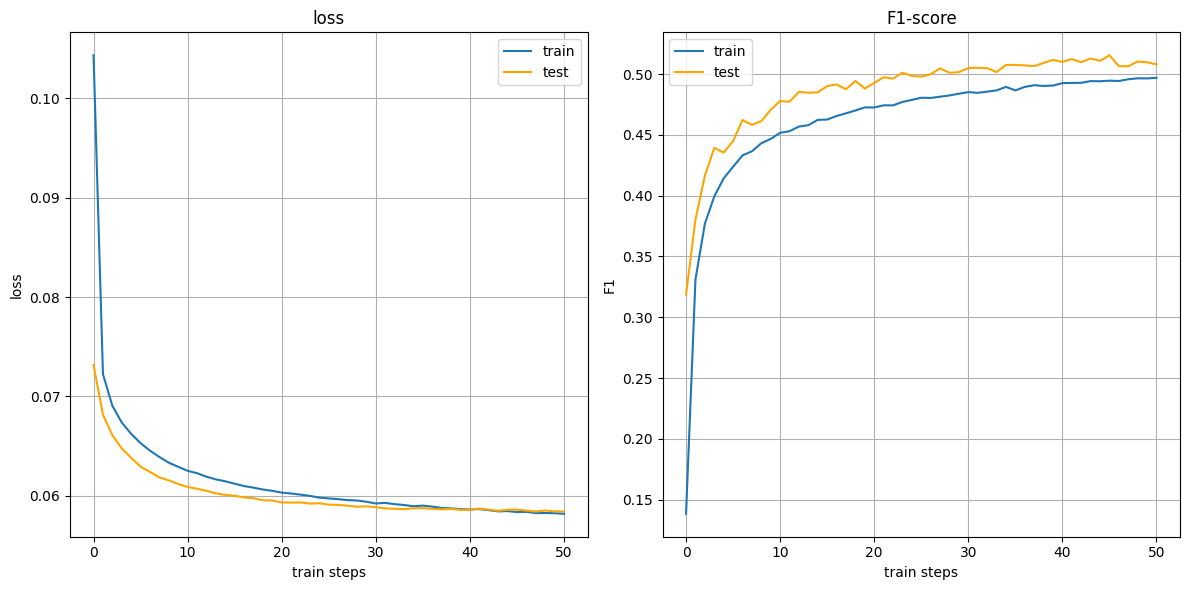

In [15]:
# Визуализируем для хабов
mu.plot_history(train_loss_log, train_f1_log, test_loss_log, test_f1_log, figsize=(12,6))

`Выводы для модели хабов`
* На графике потерь видно, что на тренировочной и тестовой выборках loss снижается в начале обучения (~10 000 шагов) и стабилизируется на уровне 0.05-0.06 (довольно низкий loss), то есть модель успешно сходится и не переобучается (что видно также по близким метрикам train f1 - 0.497 и test f1 - 0.508)
* Итоговые значения на тестовой выборке f1-score (micro) 0.508, что говорит о среднем качестве предсказаний, при этом виден значительный перевес в сторону точности (precision - 0.704) в сравнении с полнотой (recall 0.397) - этот же перекос наблюдался и раньше при экспериментах с классическими ML-моделями, hamming loss довольно низкий (0.02), то есть доля ошибочно предсказанных меток мала

In [16]:
# Обучаем модель для рейтинга
(train_loss_log, train_f1_log, test_loss_log, 
test_f1_log, test_prec_log, test_rec_log, 
test_ham_log) = train(
    fcnet_r, optimizer_r, 26, train_loader_r, 
    test_loader_r, train_epoch, test, 
    task_type='rating', criterion=nn.CrossEntropyLoss(), 
    model_type='fc', scheduler=scheduler_r)

Epoch 0
 train loss: 1.1623, train f1: 0.4563
 test loss: 1.1363, test f1: 0.4732, test hamming: 0.5268

Epoch 5
 train loss: 1.1163, train f1: 0.4827
 test loss: 1.1161, test f1: 0.4819, test hamming: 0.5181

Epoch 10
 train loss: 1.1055, train f1: 0.4889
 test loss: 1.1105, test f1: 0.4868, test hamming: 0.5132

Epoch 15
 train loss: 1.0986, train f1: 0.4941
 test loss: 1.1085, test f1: 0.4847, test hamming: 0.5153

Epoch 20
 train loss: 1.0884, train f1: 0.4988
 test loss: 1.1051, test f1: 0.4880, test hamming: 0.5120

Epoch 25
 train loss: 1.0876, train f1: 0.5020
 test loss: 1.1048, test f1: 0.4889, test hamming: 0.5111



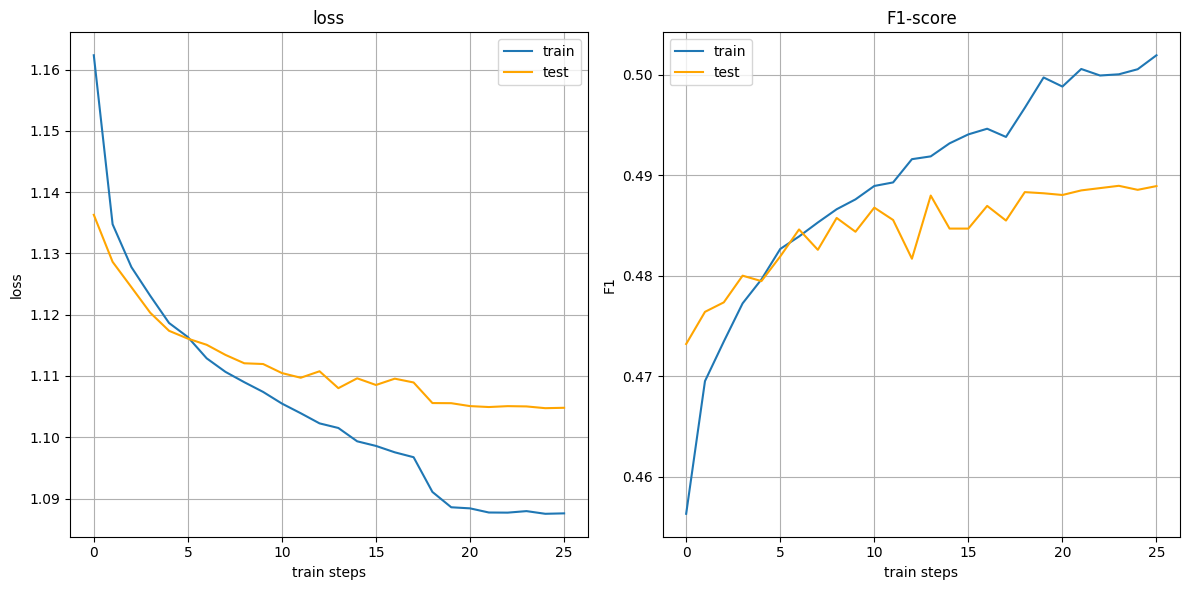

In [17]:
# Визуализируем для рейтинга
mu.plot_history(train_loss_log, train_f1_log, test_loss_log, test_f1_log, figsize=(12,6))

`Выводы для модели рейтинга`
* Также можем наблюдать начало графика потерь с высокого loss, с его постепенным уменьшением по мере увеличения количества шагов, разница между train и test f1-score на последней эпохе тоже не велика (0.502 и 0.489 соответственно), сильного переобучения не наблюдается
* F1-score находится на уровне 50%, что говорит о среднем качестве получнных предсказаний для полносвязной модели, при этом hamming loss довольно высокий - 0.511, практически половина предсказанных меток ошибочны
* Что интересно - модель уже с первой эпохи выходит на приемлемые значения метрики test f1-score (0.473), тогда как для модели хабов этот процесс был более постепенным (от низких значений на первых эпохах до более высоких на поздних)

## Рекуррентная модель

### Предобработка данных

In [19]:
X = df_prepr.drop(columns=['author', 'publication_date', 'url', 'text_pos_tags', 'hubs', 'rating_level', 'rating_new', 'hubs_encoded']).copy()

# Кодировка individ/company
X['individ/company'] = X['individ/company'].map({'individual': 0, 'company': 1})
X = X.rename(columns={'individ/company':'is_company'})

# Матрица признаков
X_hubs = X.iloc[indices].copy()
X_rating = X.copy()

# Выделяем нужные столбцы
num_cols= ['comments', 'views', 'reading_time', 'bookmarks_cnt', 'text_length']

# Разделение на обучающую и тестовую выборки для предсказания хабов (тем) статей
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_hubs, y_multi_reduced, test_size=0.25)

# Разделение на обучающую и тестовую выборки для предсказания рейтинга статьи
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_rating, y_rating, test_size=0.25)

In [20]:
# Табличные данные
X_train_h_num = X_train_h[num_cols].to_numpy()
X_test_h_num = X_test_h[num_cols].to_numpy()
X_train_r_num = X_train_r[num_cols].to_numpy()
X_test_r_num = X_test_r[num_cols].to_numpy()

# Масштабирование табличных данных
scaler_h = StandardScaler()
X_train_h_num = scaler_h.fit_transform(X_train_h_num)
X_test_h_num = scaler_h.transform(X_test_h_num)

scaler_r = StandardScaler()
X_train_r_num = scaler_r.fit_transform(X_train_r_num)
X_test_r_num = scaler_r.transform(X_test_r_num)

# Обработка текстовых данных
train_texts_h = X_train_h['text_combined'].str.split().tolist()
test_texts_h = X_test_h['text_combined'].str.split().tolist()
train_texts_r = X_train_r['text_combined'].str.split().tolist()
test_texts_r = X_test_r['text_combined'].str.split().tolist()

In [ ]:
# Функция создания словаря из всех токенов
def build_vocab(tokenized_texts, max_vocab_size=10000):
    # Объединяем все токены из train, выбирая 10 000 самых частотных
    all_tokens = [token for tokens in tokenized_texts for token in tokens]
    vocab = Counter(all_tokens)
    most_common = vocab.most_common(max_vocab_size)
    
    # Маппинг word to index
    word_to_idx = {word: idx + 2 for idx, (word, _) in enumerate(most_common)}
    word_to_idx['<PAD>'] = 0
    word_to_idx['<UNK>'] = 1
    return word_to_idx

word_to_idx_h = build_vocab(train_texts_h)
word_to_idx_r = build_vocab(train_texts_r)

# Преобразование токенов в индексы
def tokens_to_indices(tokenized_texts, word_to_idx, max_len):
    indices = []
    for tokens in tokenized_texts:
        token_ids = [word_to_idx.get(token, word_to_idx['<UNK>']) for token in tokens][:max_len]
        token_ids += [word_to_idx['<PAD>']] * (max_len - len(token_ids))
        indices.append(token_ids)
    return torch.tensor(indices, dtype=torch.long)

# Максимальное количество токенов в каждой последовательности
max_len = 100
train_indices_h = tokens_to_indices(train_texts_h, word_to_idx_h, max_len)
test_indices_h = tokens_to_indices(test_texts_h, word_to_idx_h, max_len)

train_indices_r = tokens_to_indices(train_texts_r, word_to_idx_r, max_len)
test_indices_r = tokens_to_indices(test_texts_r, word_to_idx_r, max_len)

In [22]:
# DataLoader для RNN
def make_loader_rnn(X, text, y, task_type, shuffle=True):
    X_t = torch.from_numpy(X).float()
    text_t = text # уже torch.longs
    if task_type == 'hubs':
        y_t = torch.from_numpy(np.array(y)).float()
    elif task_type == 'rating':
        y_t = torch.from_numpy(np.array(y)).long()
    ds = TensorDataset(X_t, text_t, y_t)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)


train_loader_h = make_loader_rnn(X_train_h_num, train_indices_h, 
                                 y_train_h, task_type='hubs', shuffle=True)
test_loader_h = make_loader_rnn(X_test_h_num, test_indices_h, 
                                y_test_h, task_type='hubs', shuffle=False)

train_loader_r = make_loader_rnn(X_train_r_num, train_indices_r, 
                                 y_train_r, task_type='rating', shuffle=True)
test_loader_r = make_loader_rnn(X_test_r_num, test_indices_r, 
                                y_test_r, task_type='rating', shuffle=False)

### Архитектура нейросети, обучение

In [23]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_input, hidden_size, n_classes, dropout):
        super().__init__()
        # Слой эмбеддингов для текстов
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.dropout_embed = nn.Dropout(dropout)

        # Табличные признаки
        self.tabular_net = nn.Sequential(
        nn.Linear(num_input, hidden_size),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(hidden_size, hidden_size//2),
        nn.ReLU())
        
        # Текстовые признаки
        self.gru = nn.GRU(embed_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size//2 + hidden_size, n_classes)
    
    def forward(self, tabular, text):
        # Обработка табличных данных
        tabular_out = self.tabular_net(tabular)

        # Обработка текстовых данных
        embedded = self.embedding(text)
        embedded = self.dropout_embed(embedded)
        gru_out, hn = self.gru(embedded)
        text_out = hn[-1]

        # Объединяем
        combined = torch.cat((tabular_out, text_out), dim=1)
        pred = self.fc(combined)
        return pred

In [ ]:
# Задаём модели
# Увеличим вес положительных меток для хабов для меньшего переобучения
pos_weight = torch.ones(n_classes_h).to(device) * 3
criterion_h = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Модель хабов
rnn_h = RNN(vocab_size=len(word_to_idx_h), embed_dim=128, 
            num_input=len(num_cols), hidden_size=256,
            n_classes=n_classes_h, dropout=0.4).to(device)
optimizer_h = torch.optim.Adam(rnn_h.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_h = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_h, mode='min', factor=0.1, patience=3)

# Модель рейтинга
rnn_r = RNN(vocab_size=len(word_to_idx_r), embed_dim=64, 
            num_input=len(num_cols), hidden_size=128,
            n_classes=n_classes_r, dropout=0.5).to(device)
optimizer_r = torch.optim.Adam(rnn_r.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_r = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_r, mode='min', factor=0.1, patience=3)

In [25]:
# Обучаем модель хабов
(train_loss_log, train_f1_log, test_loss_log, 
test_f1_log, test_prec_log, test_rec_log, 
test_ham_log) = train(
    rnn_h, optimizer_h, 26, train_loader_h, 
    test_loader_h, train_epoch, test, 
    task_type='hubs', criterion=criterion_h, 
    model_type='rnn', scheduler=scheduler_h)

Epoch 0
 train loss: 0.2228, train f1: 0.2243
 test loss: 0.1805, test f1: 0.4030, test precision: 0.4894, test recall: 0.3426, test hamming: 0.0271

Epoch 5
 train loss: 0.1360, train f1: 0.5361
 test loss: 0.1361, test f1: 0.5377, test precision: 0.5662, test recall: 0.5119, test hamming: 0.0235

Epoch 10
 train loss: 0.1323, train f1: 0.5459
 test loss: 0.1333, test f1: 0.5420, test precision: 0.5468, test recall: 0.5372, test hamming: 0.0242

Epoch 15
 train loss: 0.1299, train f1: 0.5512
 test loss: 0.1326, test f1: 0.5482, test precision: 0.5571, test recall: 0.5396, test hamming: 0.0237

Epoch 20
 train loss: 0.1288, train f1: 0.5554
 test loss: 0.1304, test f1: 0.5559, test precision: 0.5537, test recall: 0.5581, test hamming: 0.0238

Epoch 25
 train loss: 0.1121, train f1: 0.6040
 test loss: 0.1235, test f1: 0.5757, test precision: 0.5543, test recall: 0.5990, test hamming: 0.0236



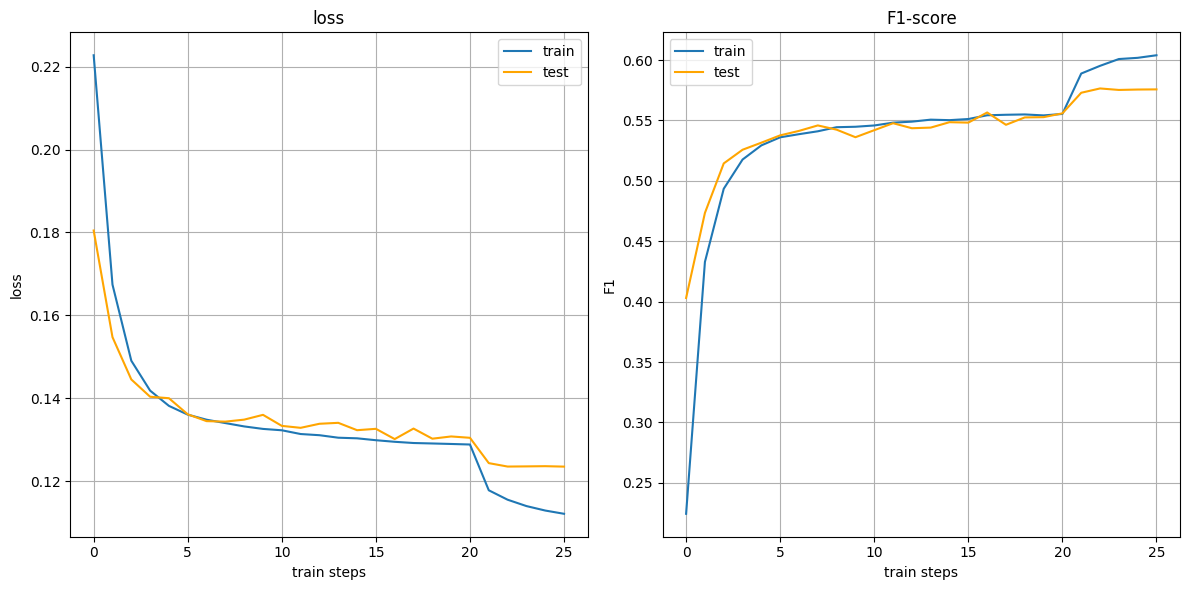

In [26]:
# Визуализируем для хабов
mu.plot_history(train_loss_log, train_f1_log, test_loss_log, test_f1_log, figsize=(12,6))

`Выводы для хабов`
* RNN-модель показала более хорошую предсказательную способность в сравнении с полносвязной моделью - test f1-score вырос с 0.5081 до 0.576
* Разница между train и test f1-score (0.604 и 0.576) указывает на некоторый рост переобучения модели (что также наблюдается в графиках на последних эпохах)
* Метрики Precision и Recall выровнялись по сравнению с полносвязной моделью (precision: 0.704 -> 0.554, recall: 0.397 -> 0.599), hamming loss остался примерно на том же уровне 

In [ ]:
# Обучаем модель рейтинга
(train_loss_log, train_f1_log, test_loss_log, 
test_f1_log, test_prec_log, test_rec_log, 
test_ham_log) = train(
    rnn_r, optimizer_r, 26, train_loader_r, 
    test_loader_r, train_epoch, test, 
    task_type='rating', criterion=nn.CrossEntropyLoss(), 
    model_type='rnn', scheduler=scheduler_r)

Epoch 0
 train loss: 0.9867, train f1: 0.5691
 test loss: 0.9354, test f1: 0.5969, test hamming: 0.4031

Epoch 5
 train loss: 0.8266, train f1: 0.6491
 test loss: 0.8398, test f1: 0.6435, test hamming: 0.3565

Epoch 10
 train loss: 0.7167, train f1: 0.7048
 test loss: 0.8746, test f1: 0.6332, test hamming: 0.3668

Epoch 15
 train loss: 0.6796, train f1: 0.7200
 test loss: 0.9003, test f1: 0.6302, test hamming: 0.3698

Epoch 20
 train loss: 0.6768, train f1: 0.7224
 test loss: 0.9034, test f1: 0.6298, test hamming: 0.3702

Epoch 25
 train loss: 0.6762, train f1: 0.7229
 test loss: 0.9036, test f1: 0.6298, test hamming: 0.3702



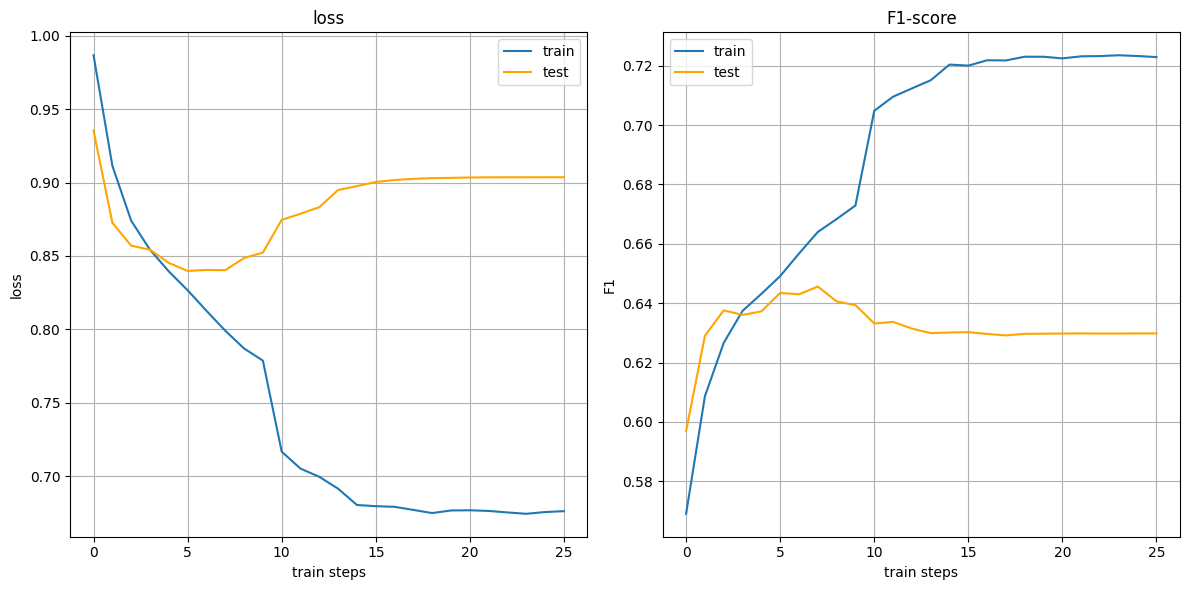

In [28]:
# Визуализируем для рейтинга
mu.plot_history(train_loss_log, train_f1_log, test_loss_log, test_f1_log, figsize=(12,6))

`Выводы для модели рейтинга`
* По графикам заметно переобучение модели, loss для тренировочных данных всё время падает, а для тестовых ~ с 7 эпохи начинает расти и затем стабилизируется после 15-й эпохи, аналогичная картина наблюдается для test f1-score (micro)
* По сравнению с полносвязной моделью RNN показывает прирост практически в 14% по метрике test f1-score (0.489 против 0.629), hamming loss при этом тоже снизился (с 0.511 до 0.370)

## Итоговые выводы

* Среди DL-моделей для предсказаний тем статей лучшие микро-метрики показала RNN-модель (test f1: 0.5757, test precision: 0.5543, test recall: 0.5990, test hamming: 0.0236), а для предсказаний рейтинга также RNN-модель с микро-метриками (test f1: 0.6298, test hamming: 0.3702)
* По сравнению с нелинейными моделями - DL-модели (RNN) показывают практически сопоставимое качество в обеих задачах, в случае тем статей лучшие микро-метрики для модели CatBoostClassifier (test precision: 0.7591, test recall: 0.4352, test f1: 0.5532, test hamming: 0.0187), при этом для DL модели заметен баланс между precision и recall, а для CatBoost precision значимо выше, для модели рейтинга лучшей моделью был RandomForestClassifier (test f1: 0.6526, test hamming: 0.3474)
* Итоговыми моделями для задач нашего проекта оставим нелинейные модели из предыдущего этапа (так как дают большую точность предсказаний), применим их на следующем этапе по обновления сервиса